<a href="https://colab.research.google.com/github/Vernalhav/numeric_methods/blob/master/numerico_aplicacoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Victor Giovannoni Vernalha  
victor Graciano de Souza Correia  
  
  

> **Índice**
* [Funções Auxiliares](#scrollTo=tQpsV8q-mmzF)
* [Tema 1: Resolução de Sistemas Lineares](#scrollTo=lzj6vaF83Kwo)
    * [Revisão Teórica](#scrollTo=E5M_JkgY5GfU&line=1&uniqifier=1)
    * [Implementação (Gauss-Seidel e Eliminação de Gauss)](#scrollTo=C4Wo1WcX5SSE)
    * [Comparação com a implementação do NumPy](#scrollTo=9ln7vvKPYxUh)
    * [Aplicação: comparação de Métodos diretos e iterativos](#scrollTo=TmV9aOpr5WL7)
* [Tema 2: Interpolação polinomial](#scrollTo=MH9gItlVo0hC)
    * [Revisão Teórica](#scrollTo=AcP4UamIpZSb)
    * [Implementação (Polinômio de Lagrange)](#scrollTo=2IsUd6QopnEU)
    * [Comparação com a implementação do SciPy](#scrollTo=a4dLAtsZYsHu)
    * [Aplicação: Aproximação de funções por _samples_](#scrollTo=Dto-G6FOpvOf)
* [Tema 3: ??](#scrollTo=zU7SMAoP3W_S)
* [Tema 4: Métodos dos autovalores e autovetores](#scrollTo=JYTL7Qnh3dSx)
    * [Revisão Teórica](#scrollTo=DkfY-I4h7GDJ)
    * [Implementação (Francis e SVD)](#scrollTo=6AuohDWh7GDP)
    * [Comparação com a implementação do NumPy](#scrollTo=JIchMEwzYJ7f)
    * [Aplicação: Compressão de imagens](#scrollTo=VfjSjBAu7GDT)


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Funções auxiliares

In [2]:
def compare_implementation(Xs, errors, times, linearize_x=False, foreground='np',\
                           x_label='N', title='NumPy implementation comparison',\
                           err_metric='Absolute Difference between implementations'):
    """
    Visualize the difference in performance and result
    between our implementation and NumPy's.

    Xs:         array of X values for which the errors and times were calculated
    errors:     array of errors between our result and NumPy's
    times:      tuple containing 2 arrays: our execution times and NumPy's execution times 
    linearize_x: whether to make x entries evenly spaced (retaining Xs labels) 
    foreground: 'ours' or 'np'. Which bars to put in the foreground
    x_label:    label to give to the x axis
    title:      graph title
    err_metric: label for the error scatterplot
    """

    fig, ax = plt.subplots()
    linear_x = np.arange(len(errors))

    ax.set_xticks([Xs, linear_x][linearize_x])
    ax.xaxis.set_ticklabels(Xs)
    ax.set_title(title)

    time_ax = ax.twinx()
    time_ax.bar([Xs, linear_x][linearize_x], times[0], label='Our execution times', zorder=[1, -1][foreground=='np'])
    time_ax.bar([Xs, linear_x][linearize_x], times[1], label='NumPy\'s execution times', zorder=[-1, 1][foreground=='np'])

    ax.scatter([Xs, linear_x][linearize_x], errors, label=err_metric, color='red', zorder=1)

    time_ax.set_zorder(0)
    ax.set_zorder(1)
    ax.patch.set_visible(False)

    ax.legend(loc='upper left', fontsize='medium', bbox_to_anchor=(1.2, 0.8))
    time_ax.legend(loc='upper left', fontsize='medium', bbox_to_anchor=(1.2, 1))

    time_ax.set_ylabel('Time (s)')
    ax.set_ylabel('Absolute difference')

    plt.show()

In [70]:
import time

def timeit(f):
    """
    Decorator that times a function
    execution speed and returns a tuple
    with the elapsed time and the function
    return value(s).
    """

    def time_f(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        return (time.time() - start, result)

    return time_f

In [4]:
@timeit
def numpy_wrapper(numpy_function, *args, **kwargs):
    return numpy_function(*args, **kwargs)


@timeit
def implementation_wrapper(implementation_function, *args, **kwargs):
    return implementation_function(*args, **kwargs)

# **Tema 1: Resolução de Sistemas Lineares**

## Revisão Teórica

### Sistemas Lineares
Um sistema linear de ordem $n$ pode ser escrito como
$$Ax = b \quad A \in \mathbb{M}_n(\mathbb{R}) \; x, b \in \mathbb{R}^n$$
com $A, b$ dados. O objetivo do sistema é encontrar o vetor $x$ tal que a igualdade seja satisfeita.  
  
### Métodos de Resolução de Sistemas
Existem algoritmos para solucionar esses sistemas, e eles são divididos em duas grandes categorias: os métodos diretos e os métodos iterativos. Os métodos diretos encontram a solução numérica de maneira "exata" (descontando erros de arredondamento inerentes às operações computacionais). Os métodos iterativos, quando convergem, encontram uma solução que pode ser arbitrariamente próxima da solução real.  
  
Nessa aplicação, decidimos comparar os métodos de Eliminação de Gauss e o método Gauss-Seidel.  
A eliminação de Gauss consiste em escalonar a matriz $A$ e o vetor $b$ de modo que $A$ fique diagonal superior e o sistema seja equivalente, para que seja solucionado por substituições trivialmente.  
  
O método Gauss-Seidel consiste em executar um processo iterativo com o objetivo de encontrar vetores $x$ que convergem para a solução do sistema.

### Eliminação de Gauss
O método que estamos utilizando como método direto é a Eliminação de Gauss, o qual consiste em aplicar sucessivas operações elementares num sistema linear, para o transformar num sistema de mais fácil resolução, que apresenta exatamente as mesmas soluções que o original, sendo ela uma matriz triangular superior.

Considere um sistema geral de $n$ equações lineares de $n$ incógnitas:

\begin{align} \left\{\begin{matrix} a_{11}x_1 + a_{12}x_2 + ... + a_{1n}x_n = b_1 \\a_{21}x_1 + a_{22}x_2 + ... + a_{2n}x_n = b_2 \\ \: \vdots \quad \quad \quad \vdots \quad \quad \: \: \quad \vdots \quad \quad \: \: \vdots \: \: \: \\ a_{m1}x_1 + a_{m2}x_2 + ... + a_{mn}x_n = b_m \end{matrix}\right. \end{align}

Suponha que esse sistema realmente tenha uma solução (ou seja, a matriz do coeficiente não é singular). Agora pegue matriz de coeficientes $A$ para este sistema e junte-se à matriz de colunas $b = \begin{bmatrix} b_1 \\ b_2 \\ \vdots \\ b_n \end{bmatrix}$. Denotamos essa nova matriz aumentada $n×n+1$ como $[A|b]$.

\begin{align} \quad [ \: A \: | \: b \: ] = \begin{bmatrix} a_{11} & a_{12} & \cdots & a_{1n} & b_1 \\ a_{21} & a_{22} & \cdots & a_{2n} & b_2 \\ \vdots & \vdots & \ddots & \vdots & \vdots \\ a_{n1} & a_{n2} & \cdots & a_{nn} & b_n \end{bmatrix} \end{align}

Nosso objetivo é usar operações de linha elementares para transformar a matriz aumentada acima no seguinte formato:

\begin{align} \quad \begin{bmatrix} u_{11} & u_{12} & \cdots & u_{1n} & b_1 \\ 0 & u_{22} & \cdots & u_{2n} & b_2 \\ \vdots & \vdots & \ddots & \vdots & \vdots \\ 0 & 0 & \cdots & u_{nn} & b_n \end{bmatrix} \end{align}

Em outras palavras, queremos reduzir a matriz do coeficiente $A$ para que ela seja uma matriz triangular superior ao aplicar as mesmas operações de linha elementares à matriz $b$. A matriz acima é equivalente à linha da matriz aumentada do nosso sistema e, portanto, as soluções para essa matriz são as mesmas que as soluções para as equações do sistema original. O benefício de ter a matriz acima é que é muito mais simples de resolver. Observe que a matriz aumentada acima é equivalente ao seguinte sistema de equações:

\begin{align} \left\{\begin{matrix} u_{11}x_1 + u_{12}x_2 + ... + u_{1n}x_n = b_1 \\0x_1 + u_{22}x_2 + ... + u_{2n}x_n = b_2 \\ \: \vdots \quad \quad \quad \vdots \quad \: \: \quad \vdots \quad \quad \: \: \vdots \: \\ 0x_1 + 0x_2 + ... + u_{nn}x_n = b_m \end{matrix}\right. \end{align}

Percebemos que $x_n = b_n$. Podemos então pegar isso e substituí-lo na equação $x_n − 1 + a_{(n − 1, n)}x_n = b_{n − 1}$ e resolver $x_{n − 1}$. Repetindo esse processo e obtemos toda a solução para o sistema original por substituição posterior sucessiva. Toda essa técnica é conhecida como Eliminação Gaussiana e é um bom método para resolver sistemas de equações $n$ com variáveis ​​$n$.

Agora, vamos dar uma olhada no algoritmo de eliminação gaussiano. Para esse algoritmo, assumiremos que nem todos estamos dividindo por zero (veremos isso mais adiante). Deixe $E(k)$ denotar a equação $k^{th}$ em nosso sistema de $n$ equações em $n$ variáveis ​​para $k = 1,2, ..., n$. Nosso sistema pode ser escrito da seguinte forma:

\begin{align} \quad \begin{matrix} E(1): & & a_{11}^{(1)}x_1 & + & a_{12}^{(1)}x_2 & + & \cdots & + & a_{1n}^{(1)}x_n & = & b_1^{(1)} \\ E(2): & & a_{21}^{(1)}x_1 & + & a_{22}^{(1)}x_2 & + & \cdots & + & a_{2n}^{(1)}x_n & = & b_2^{(1)} \\ \vdots & & \vdots & & \vdots & & \ddots & & \vdots & & \vdots \\ E(n): & & a_{n1}^{(1)}x_1 & + & a_{n2}^{(1)}x_2 & + & \cdots & + & a_{nn}^{(1)}x_n & = & b_n^{(1)} \end{matrix} \end{align}

O primeiro passo que queremos fazer é eliminar a variável $x_1$ das equações $E(2)$ a $E(n)$. Isso fará com que nosso sistema de equações tenha zeros embaixo da entrada $a_{11}^{(1)}x_1$.Ao fazer isso, obtemos o sistema equivalente abaixo.

\begin{align} \quad \begin{matrix} E(1): & & a_{11}^{(1)}x_1 & + & a_{12}^{(1)}x_2 & + & \cdots & + & a_{1n}^{(1)}x_n & = & b_1^{(1)} \\ E(2): & & 0 & + & a_{22}^{(2)}x_2 & + & \cdots & + & a_{2n}^{(2)}x_n & = & b_2^{(2)} \\ \vdots & & \vdots & & \vdots & & \ddots & & \vdots & & \vdots \\ E(n): & & 0 & + & a_{n2}^{(2)}x_2 & + & \cdots & + & a_{nn}^{(2)}x_n & = & b_n^{(2)} \end{matrix} \end{align}

Temos que $m_{21} = \frac{a_{21}^{(1)}}{a_{11}^{(1)}}$, $m_{31} = \frac{a_{31}^{(1)}}{a_{11}^{(1)}}$, …, $m_{n1} = \frac{a_{n1}^{(1)}}{a_{11}^{(1)}}$. Em seguida, os coeficientes $a_{ij}^{(2)}$ and $b_i^{(2)}$ na matriz acima podem ser obtidos com as seguintes fórmulas:

\begin{align} \quad a_{ij}^{(2)} = a_{ij} - m_{i1}a_{1j} \quad i, j = 2, 3, ..., n \\ \quad b_1^{(2)} = b_i - m_{i1}b_1 \quad i = 2, 3, ..., n \end{align}

Na etapa $ k ^ {th} $, teremos a seguinte matriz (parcialmente reduzida) para trabalhar:

\begin{align} \quad \begin{matrix} E(1): & & a_{11}^{(1)}x_1 & + & a_{12}^{(1)}x_2 & + & \cdots & + & \cdots & + & a_{1n}^{(1)}x_n & = & b_1^{(1)}\\ E(2): & & 0 & + & a_{22}^{(2)}x_2 & + & \cdots & + & \cdots & + & a_{2n}^{(2)}x_n & = & b_2^{(2)} \\ \vdots & & \vdots & & \vdots & & & & & & \vdots & & \vdots \\ E(k): & & 0 & + & 0 & + & a_{kk}^{(k)}x_k & + & \cdots & + & a_{kn}^{(k)}x_n & = & b_k^{(k)} \\ \vdots & & \vdots & & \vdots & & & & & & \vdots & & \vdots \\ E(n): & & 0 & + & 0 & + & a_{nk}^{(k)}x_k & + & \cdots & + & a_{nn}^{(k)}x_n & = & b_n^{(k)} \end{matrix} \end{align}

Nesta etapa, queremos eliminar a variável $ x_k $ das equações $E(k + 1)$ a $E(n)$. Isso fará com que todas as entradas abaixo de $a_{kk}^{(k)}x_k$ sejam zero.

Temos que $m_{ik} = \frac{a_{ik}^{(k)}}{a_{kk}^{(k)}}$ para $i=k+1,k+2,...,n$. Para as equações $E(k+1), E(k+2), …, E(n)$, subtrairemos $m_{ik}$ vezes $ E (k) $ de $E(i)$ para cada $i=k+1,k+2,...,n$. Os coeficients abaixo da equação $E(k)$ serão:

\begin{align} \quad a_{ij}^{(k+1)} = a_{ij}^{(k)} - m_{ik}a_{kj}^{(k)} \quad \quad i, j = k+1, k+2, ..., n \\ \quad b_i^{(k+1)} = b_i^{(k)} - m_{ik}b_k^{(k)} \quad \quad i = k+1, k+2, ... , n \end{align}

No passo $(n−1)^{th}$, o sistema será transformado em uma forma equivalente "triangular superior":

\begin{align} \quad u_{11}x_1 + u_{12}x_2 + \cdots + u_{1n} x_n = g_2 \\ u_{22}x_2 + \cdots + u_{2n} x_n = g_2 \\ \vdots \\ u_{nn}x_n = g_n \end{align}

Os coeficientes desse sistema equivalente de linha que designaremos como $u_{ij}=a_{ij}^{(i)}$ e $g_i=b_1^{(i)}$ para $i=1,2,...,n$. Em seguida, procedemos à resolução desse sistema de equações por substituição inversa. Temos isso para $i=n−1,n−2,...,1$:

\begin{align} \quad x_n = \frac{g_n}{u_{nn}} \quad , \quad x_{n-1} = \frac{g_{n-1} - u_{(n-1, n)}x_n}{u_{(n-1, n-1)}} \quad \cdots \quad x_{i} = \frac{g_i - \sum_{j=i+1}^{n} u_{ij}x_j}{u_{ii}} \end{align}

------------------------------------------------------------------------------

### Gauss-Seidel
Já o método iterativo utilizado é o método de Gauss-Seidel, o qual é semelhante ao método de Jacobi, os quais obedecem ao mesmo critério de convergência. A condição suficiente de convergência é que a matriz seja estritamente diagonal dominante, isto é, fica garantida a convergência da sucessão de valores gerados para a solução exata do sistema linear.
A iteração Gauss-Seidel é dada pela seguinte fórmula: 

$$ x^{(k+1)}=\left({D+L}\right)^{-1}\left({-Ux^{(k)}+b}\right) $$

Onde a matriz $A$ é igual a soma das matrizes $D, L, $ e $U$; as matrizes $D$, $L$, e $U$ representam respectivamente os coeficientes da matriz $A$: a diagonal, triangular estritamente inferior, e triangular estritamente superior; e $k$ é o contador da iteração. 
Esta expressão matricial é utilizada principalmente para analisar o método.
Quando implementada, Gauss-Seidel, uma aproximação explícita de entrada por entrada é utilizada:

$$x^{(k+1)}_i  = \frac{1}{a_{ii}} \left(b_i - \sum_{j<i}a_{ij}x^{(k+1)}_j-\sum_{j>i}a_{ij}x^{(k)}_j\right),\, i=1,2,\ldots,n.$$

Diferenciando-se do método de Gauss-Jacob:

$$x^{(k+1)}_i = \frac{1}{a_{ii}} \left(b_i - \sum_{j=1,j\ne i}^{n} a_{ij}x_{j}^{(k)}\right),\, i=1,2,\ldots,n.$$

O método de Gauss-Seidel apresenta convergência mais rápida do que o de Gauss-Jacob.

Note que o cálculo de $x^{(k+1)}_i$ utiliza apenas os elementos de $x^{(k+1)}\ $, que já havia sido calculada e apenas aqueles elementos de $ x^{(k)}\ $, já haviam avançado para a iteração $ k+1 $. Isto significa que nenhum armazenamento adicional é necessário, e que computacionalmente pode ser substituído $ x^{(k)}\ $, por $ x^{(k+1)}\, $. A iteração geralmente continua até que a solução esteja dentro da tolerância especificada.

## Implementação (Gauss-Seidel e Eliminação de Gauss)

### Funções Auxiliares

In [5]:
def get_matrix(n, matrix_type):
    '''
    Returns a matrix with dimension n x n

    matrix_type can be either
        'diag dominant' : Diagonally dominant (Gauss-Seidel always converges)
        'SPD'           : Symetrically Positive Definite
        'Semi SPD'      : Symetrucally Positive Semi-Definite
        'random'        : Random elements
    '''
    A = np.random.rand(n, n)

    if (matrix_type == 'Semi SPD'): return np.dot(A, A.T)

    if (matrix_type == 'SPD'): return np.dot(np.tril(A), np.tril(A).T)

    if (matrix_type == 'random'): return A

    if (matrix_type == 'diag dominant'):
        for i in range(n):
            A[i, i] += np.sum(np.abs(A[i, :]))
        return A

In [6]:
INF = 2**32

def absolute_error(v1, v2):
    error = np.linalg.norm(v1 - v2)
    return error if not np.isnan(error) else INF


def gauss_seidel_convergence(A):
    '''
    Returns boolean indicating whether or
    not Gauss-Seidel converges with A
    '''
    n = A.shape[0]
    beta = np.zeros((n, 1))
    beta[0] = np.sum(np.abs(A[0, 1:]))/np.abs(A[0, 0])
    if beta[0] >= 1: return False

    for i in range(1, n):
        # Since beta is initialized as 0, we can
        # do the dot product without worrying
        # about the row slice
        beta[i] = (np.dot(np.abs(A[i,:]), beta) +
                  np.sum(np.abs(A[i, i+1:])))/np.abs(A[i, i])
        if beta[i] >= 1: return False

    return True

In [7]:
def get_range(start, end):
    ''' Returns increasing np range if start < end, or decreasing if end < start '''
    if start <= end:
        return np.arange(start, end, 1)
    else:
        return np.arange(start, end, -1)


def check_triangular(A):
    ''' Checks if A is upper or lower triangular, or neither '''
    if np.allclose(A, np.tril(A)): return 'lower'
    if np.allclose(A, np.triu(A)): return 'upper'
    if np.allclose(A, np.diag(np.diag(A))): return 'diagonal'    
    return 'neither'

In [8]:
def substitution(T, b):
    '''
    Given T a triangular matrix,
    solves Tx = b. Returns x.
    Throws ValueError if matrix
    is invalid.
    '''

    n = T.shape[0]
    start, end = 0, n

    matrix_type = check_triangular(T)
    if matrix_type == 'upper':
        # Sets up indices for regressive substitution
        start, end = n - 1, -1
    if matrix_type == 'neither':
        raise ValueError('Matrix must be either upper or lower triangular')

    x = np.zeros((n, 1))
    for i in get_range(start, end):
        result = 0
        for j in get_range(start, i):
            result += T[i][j]*x[j]
        x[i] = (b[i] - result)/T[i][i]

    return x

### Solução de sistemas por eliminação de Gauss


In [82]:
def gauss_elimination(A, b):
    '''
    Solves Ax = b using Gauss Elimination.
    Returns array x and doesn't change
    either A or b
    '''

    A = np.array(A, dtype=float)
    b = np.array(b)

    m, n = A.shape

    for cur_line in range(n-1):
        # Find the k-th pivot
        p = np.argmax(np.abs(A[cur_line : , cur_line])) + cur_line

        # Swap lines in matrix and solution vector
        A[[cur_line, p]] = A[[p, cur_line]]
        b[[cur_line, p]] = b[[p, cur_line]]

        for cur_col in range(cur_line + 1, n):
            m = -A[cur_col, cur_line]/A[cur_line, cur_line]
            A[cur_col, cur_line : ] = A[cur_col, cur_line : ] + m*A[cur_line, cur_line : ]
            b[cur_col] += m*b[cur_line]

    return substitution(A, b)

### Solução de sistemas por Gauss-Seidel

In [80]:
EPSILON = 1e-6
MAX_ITERATIONS = 1000

def gauss_seidel(A, b, tol=EPSILON, max_iterations=MAX_ITERATIONS, return_error=False):
    '''
    Given a real matrix A and an array b, solve for x
    iteratively until relative error < tol or number
    of iterations exceeds the max.

    if return_error is true, returns (x, error)
    '''
    A = np.array(A)
    n = A.shape[0]

    L_inv = np.linalg.inv(np.tril(A))
    R = np.triu(A, k=1)

    C = np.dot(-L_inv, R)
    g = np.dot(L_inv, b)

    x = np.zeros((n, 1))
    x_prev = np.zeros((n, 1))

    iterations = 0
    error = tol + 1 # Just to guarantee the first iteration

    while iterations < max_iterations and error > tol:
        x = np.dot(C, x_prev) + g
        
        iterations += 1
        error = absolute_error(np.dot(A, x), b)
        x_prev = x
        
    if return_error: return x, error
    return x

## Comparação com a implementação do NumPy

In [102]:
'''
Como as bibliotecas NumPy e SciPy não têm esses métodos explícitos,
(só disponibilizando uma função "solve" que resolve sistemas lineares),
vamos comparar as nossas implementações contra a função solve do NumPy
'''


def solution_error(x1, x2):
    """ Returns distance between x1 and x2 """
    return np.linalg.norm(x1-x2)


def compare_system_solver(solve_method, init_n=4, multiplication_step=2, n_tests=10):

    our_times = []
    numpy_times = []
    errors = []
    Ns = []

    n = init_n
    np.random.seed(42)
    for i in range(n_tests):
        Ns.append(n)

        A = get_matrix(n, 'diag dominant')
        b = np.random.rand(n, 1)

        (numpy_time, numpy_x) = numpy_wrapper(np.linalg.solve, A, b)
        (our_time, our_x) = implementation_wrapper(solve_method, A, b)

        numpy_times.append(numpy_time)
        our_times.append(our_time)

        error = solution_error(numpy_x, our_x)
        errors.append(error)

        n *= multiplication_step
    
    return Ns, errors, (our_times, numpy_times)

Como as bibliotecas NumPy e SciPy não implementam diretamente os métodos que nós escolhemos (disponibilizando apenas a função "solve" genérica para sistemas lineares), a usamos como comparação em ambos os casos.  
**OBS:** utilizamos matrizes diagonal-dominantes para que o Gauss-Seidel convergisse, já que estava produzindo resultados NaN com matrizes aleatórias.

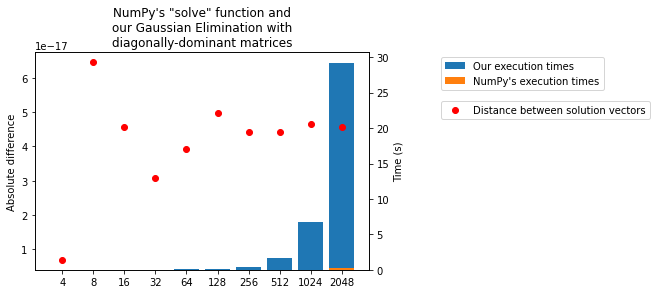

In [105]:
Xs, errors, times = compare_system_solver(gauss_elimination, n_tests=10)
compare_implementation(Xs, errors, times, linearize_x=True,\
                       title='NumPy\'s "solve" function and\nour Gaussian Elimination with\ndiagonally-dominant matrices',\
                       err_metric='Distance between solution vectors')

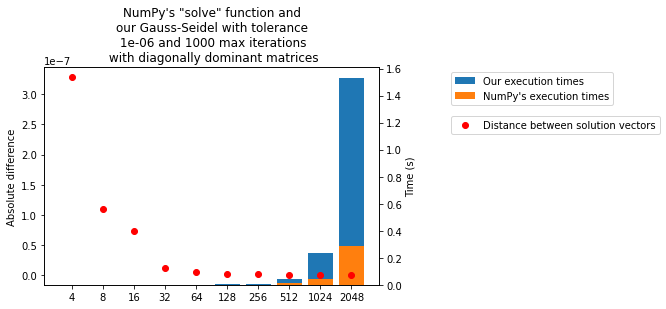

In [108]:
Xs, errors, times = compare_system_solver(gauss_seidel, n_tests=10)
compare_implementation(Xs, errors, times, linearize_x=True,\
                       title=f'NumPy\'s "solve" function and\nour Gauss-Seidel with tolerance\n {EPSILON} and {MAX_ITERATIONS} max iterations\n with diagonally dominant matrices',\
                       err_metric='Distance between solution vectors')

## Aplicação: comparação de métodos diretos e iterativos

In [11]:
def return_info(max_n=2**9, max_iterations=1e3, tol=1e-6, matrix_type='diag dominant'):
    """
    Compares Gauss-Seidel and Gauss Elimination
    using matrices of size 16 to max_n, multiplied
    by 2 each time.

    matrix_type can be either
        'diag dominant' : Diagonally dominant (Gauss-Seidel always converges)
        'SPD'           : Symetrically-Positive-Definite
        'random'        : Random elements
    """

    info = {
        'n': [],
        'gauss-elimination': {
            'times': [],
        },
        'gauss-seidel': {
            'times': [],
            'errors': []
        }
    }

    n = 16
    while n <= max_n:
        A = get_matrix(n, matrix_type)
        b = np.random.rand(n, 1)

        info['n'].append(n)

        # print(f'Testing Gauss elimination with n = {n}')
        duration, x = implementation_wrapper(gauss_elimination, A, b)
        info['gauss-elimination']['times'].append(duration)

        # print(f'Testing Gauss-Seidel with n = {n}')
        duration, (x, error) = implementation_wrapper(gauss_seidel, A, b,\
                                                      tol=tol, max_iterations=max_iterations, return_error=True)
        info['gauss-seidel']['times'].append(duration)
        info['gauss-seidel']['errors'].append(error)

        n *= 2
    
    return info

In [43]:
def compare_methods(max_n=2**9, max_iterations=1e3, tol=1e-3, matrix_type='diag dominant'):
    '''
    Plots the data collected from the comparison
    of the two methods.

    max_n represents the maximum dimension of the square matrix
    max_iterations represents the max number of iterations for Gauss-Seidel
    tol is the absolute residual tolerance for Gauss-Seidel
    matrix_type can be either
        'diag dominant' : Diagonally dominant (Gauss-Seidel always converges)
        'SPD'           : Symetrically-Positive-Definite
        'random'        : Random elements
    '''
    info = return_info(max_n, max_iterations, tol, matrix_type)

    fig, ax = plt.subplots()
    ax.set_xscale('log', basex=2)

    Ns = info['n']
    elimination_times = info['gauss-elimination']['times']
    seidel_times = info['gauss-seidel']['times']
    seidel_errors = info['gauss-seidel']['errors']

    ax.plot(Ns, elimination_times, label='Gaussian Elimination Time', marker='s', color='green')
    ax.plot(Ns, seidel_times, label='Gauss-Seidel Time', marker='s', color='orange')

    ax2 = ax.twinx()

    colormap = np.where(np.array(seidel_errors) < tol, 'b', 'r')
    ax2.scatter(Ns, seidel_errors, label='Gauss-Seidel Errors', marker='o', color=colormap)

    ax.set_ylim((0, 1 + min(60, max(max(seidel_times), max(elimination_times)))))

    ax.set_ylabel('Time (s)')
    ax.set_xlabel('N')
    ax2.set_ylabel('Absolute Residual Error')

    ax.legend(loc='upper left', fontsize='medium', bbox_to_anchor=(1.2, 1))
    ax2.legend(loc='upper left', fontsize='medium', bbox_to_anchor=(1.2, 0.8))

    plt.show()

---

Nesse exemplo, geramos matrizes dominantes diagonais para que o método de Gauss-Seidel sempre convergisse. Podemos ver que nessa circunstância, o Gauss-Seidel é a melhor opção, já que é muito mais rápido que a eliminação de Gauss e converge para todos os valores de $n$ com um erro dentro da tolerância.

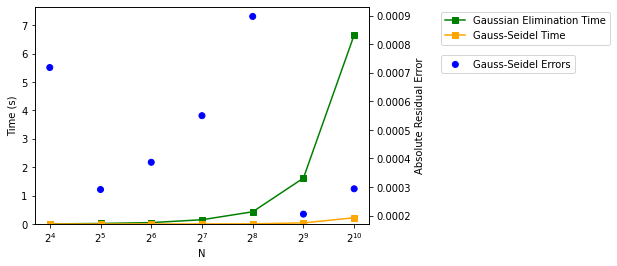

In [44]:
compare_methods(max_n=2**10, matrix_type='diag dominant')

---

Nesse exemplo, geramos matrizes Simétricas Positivas Semi-Definidas $(x^TMx \geq 0 \quad \forall\; x \in \mathbb{R}^n)$ multiplicando uma matriz aleatória por sua transposta. Nesse caso, ficam bem mais visíveis as deficiências do Gauss-Seidel. Com $10^4$ iterações, o tempo de execução dos dois métodos é muito semelhante, embora o Gauss-Seidel tenha convergido em nenhum caso (mesmo com a tolerância razoavelmente alta). Os erros exibidos, no entanto, são "pequenos", indicando que o método talvez fosse convergir se aumentássemos as iterações, mas definitivamente a eliminação de Gauss é a melhor opção, já que o seu resultado é "exato" (obtido diretamente) e tem um tempo de execução melhor.

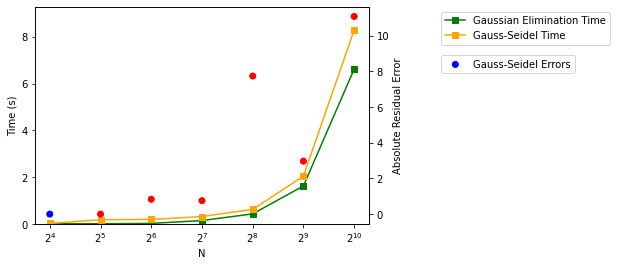

In [45]:
# Red dots indicate that Gauss-Seidel has not converged for that matrix size.
compare_methods(max_n=2**10, matrix_type='Semi SPD', max_iterations=1e4, tol=1e-3)

---

Nesse exemplo, geramos matrizes aleatórias. Podemos ver que o método de Gauss-Seidel não converge, tendo erros "infinitos" (representados por $2^{32}$).

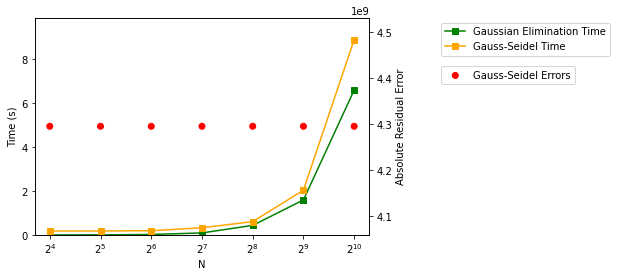

In [46]:
compare_methods(max_n=2**10, matrix_type='random', max_iterations=1e4, tol=1e-3)

---

# **Tema 2: Interpolação polinomial**

## Revisão teórica

O objetivo da interpolação polinomial é dado $n+1$ pontos $P_0, P_1, \dots P_n$, encontrar uma função polinomial $P(x)$ de grau $n$ que passe por todos os pontos dados.  
  
Optamos chegar nesse resultado através do polinômio no formato de Lagrange, já que a explicação é mais intuitiva e a implementação mais simples.  
  
Queremos encontrar um polinômio da forma $$P(x) = \sum_{k=0}^{n} y_kl_k(x)$$
Onde $l_k(x)$ é um polinômio que só depende da coordenada $x$ dos pontos dados e $y_k$ é a k-ésima coordenada $y$ dos pontos dados.  

Se o k-ésimo ponto tem coordenadas $(x_k, y_k)$, sabemos que $P(x_k) = y_k$, já que queremos que o polinômio passe por todos os pontos dados.  
Observe que uma maneira dessa condição ser atendida é para que todos os polinômios $\ l_i(x_k) = 0$ quando $i \neq k\ $ e $\ l_k(x_k) = 1$, já que o somatório iria resultar em exatamente $y_k$.  
Mas se $\ i \neq k \implies l_k(x_i) = 0$, então o conjunto $\{ x_0, \dots, x_{k-1}, x_{k+1}, \dots, x_n \}$ correspondem às raízes de $l_k(x)$.  
  
Podemos então escrever

$$ \quad l_k(x) = \alpha\prod_{\substack{i=0\\i \neq k}}^{n}(x - x_i) \tag{$\star$} $$

Observe que, de fato, o conjunto de raízes que definimos acima é satisfeito para esse polinômio. O fator $\alpha$ é necessário para representar todos os polinômios que possuem essas raízes. Para encontrar $\alpha$, basta utilizar o fato de que $l_k(x_k)=1$. Avaliando $l_k(x_k)$, temos:

$$1 = \alpha \prod_{\substack{i=0\\i \neq k}}^{n}(x_k-x_i),$$

logo

$$ \alpha = \prod_{\substack{i=0 \\ i \neq k}}^{n}(x_k - x_i)^{-1} $$
  
Portanto, substituindo $\alpha$ em $(\star)$, o nosso polinômio $l_k(x)$ é

$$l_k(x) = \prod_{\substack{i=0 \\ i \neq k}}^{n}\frac{(x - x_i)}{(x_k - x_i)}$$

  
Uma vez que definimos todos os $l_k(x)$, podemos construir $P(x)$.

## Implementação (polinômio de Lagrange)

In [16]:
def k_lagrange_polynomial(k, X):
    """
    Return the k-th lagrange polynomial as a function.
    It receives x as input and returns L_k(x)
    """
    x_k = X[k]
    X_new = np.delete(X, k)

    def k_polynomial(x):
        return np.prod((x - X_new)/(x_k - X_new))
    
    return k_polynomial

In [17]:
def lagrange_polynomial(X, Y, return_Ls=False):
    """
    Returns the polynomial that fits the given points X/Y
    as a function.
    The returned function receives x as input and returns
    P(x).

    If retuen_Ls is True, then this function returns a tuple
    with the first element being P(x) and the second is an
    array with all the L_k polynomials used to compute P(x).
    """

    X = np.array(X)
    Y = np.array(Y)
    n = X.shape[0]
    
    L = [ k_lagrange_polynomial(k, X) for k in range(n) ]

    def polynomial(x):
        L_x = np.array([ L[k](x) for k in range(n) ])
        return np.dot(Y, L_x)

    if return_Ls: return polynomial, L
    
    return polynomial

## Comparação com a implementação do SciPy

In [18]:
# NumPy doesn't have this implemented, so we're comparing it to SciPy's implementation instead
from scipy.interpolate import lagrange


def lagrange_error(poly1, poly2, n_samples):
    """
    Returns average square error between P1(x) and P2(x)
    for n_samples randomly chosen x.
    """

    X_eval = np.random.rand(n_samples)

    diff = 0
    for x in X_eval:
        diff += (poly1(x) - poly2(x))**2

    return diff/n_samples


def compare_lagrange_polynomial(init_n=3, step=1, n_tests=10, n_samples=100):

    our_times = []
    scipy_times = []
    errors = []
    Ns = []

    n = init_n
    np.random.seed(42)
    for i in range(n_tests):
        Ns.append(n)

        X = np.random.rand(n)
        Y = np.random.rand(n)

        scipy_time, scipy_poly = numpy_wrapper(lagrange, X, Y)
        our_time, our_poly = implementation_wrapper(lagrange_polynomial, X, Y)

        scipy_times.append(scipy_time)
        our_times.append(our_time)

        error = lagrange_error(scipy_poly, our_poly, n_samples)
        errors.append(error)

        n += step
    
    return Ns, errors, (our_times, scipy_times)

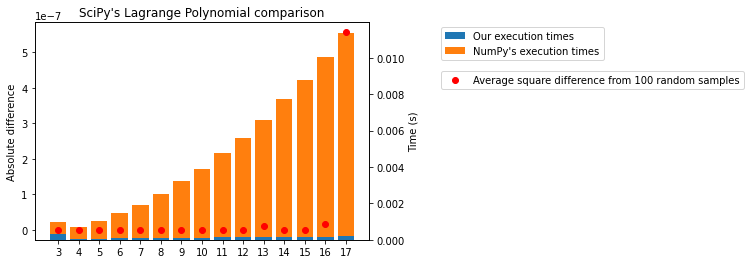

In [19]:
SAMPLES = 100
Xs, errors, times = compare_lagrange_polynomial(n_tests=15, n_samples=SAMPLES)
compare_implementation(Xs, errors, times,foreground='ours',\
                       title='SciPy\'s Lagrange Polynomial comparison',\
                       err_metric=f'Average square difference from {SAMPLES} random samples')

## Aplicação: aproximação de funções por _samples_

In [20]:
def approximate(points, x_0, show_Ls=True, show_axis=False):
    """
    Approximate a value P(x_0) given a set of points by
    fitting a polynomial through them. 
    
    Returns P(x_0), where P(x) is the lagrange polynomial
    that fits the given points and displays the computed
    polynomial.

    If show_Ls is false, do not display the L polynomials
    that were used to compute P(x). If it is true, display
    y_k*l_k(x)

    If show_axis is true, display the x axis.
    """

    X = [points[i][0] for i in range(len(points))]
    Y = [points[i][1] for i in range(len(points))]

    P, L = lagrange_polynomial(X, Y, return_Ls=True)
    
    min_x = min(X)
    max_x = max(X)

    avg_x_dist = (min_x + max_x + 1)/(2*len(X))

    # x coordinates to evaluate P(x) in
    x = np.linspace(min(x_0, min_x) - avg_x_dist, max(x_0, max(X)) + avg_x_dist, 10*len(X))

    plt.plot(x, [P(x_i) for x_i in x])  # Plot P(x)
    plt.scatter(X, Y, marker='o')       # Mark given points

    plt.scatter(x_0, P(x_0), marker='o', color='red')   # Mark x_0/P(x_0)

    if show_axis: plt.plot([x[0], x[-1]], [0, 0], color='black') # Plot x axis

    if not show_Ls:
        plt.show()
        return P(x_0)

    for i in range(len(L)):
        # Plot y_i*L_k(x)
        plt.plot(x, [Y[i]*L[i](x_i) for x_i in x], linestyle='--', alpha=0.7)

    plt.show()
    return P(x_0)

Algo interessante de se visualizar é que o polinômio $y_kl_k(x)$ gerado por cada $x_k$ se intersecta com a curva final no ponto $(x_k, y_k)$ por conta da restrição que impusemos:  $l_k(x_k) = 1$. Além disso, o polinômio é 0 para os outros pontos fornecidos por conta da outra restrição que impusemos com relação às suas raízes.

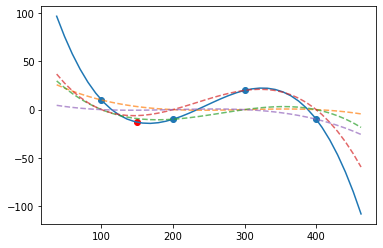

An approximation for f(150) is -13.12


In [21]:
points = [(100, 10), (200, -10), (300, 20), (400, -10)]
x_0 = 150

approx = approximate(points, x_0)
print('An approximation for f({}) is {:.2f}'.format(x_0, approx))

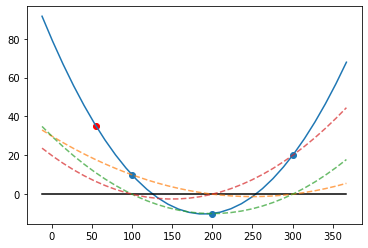

An approximation for f(55) is 35.31


In [22]:
x_0 = 55
points = [(100, 10), (200, -10), (300, 20)]

approx = approximate(points, x_0, show_axis=True)
print('An approximation for f({}) is {:.2f}'.format(x_0, approx))

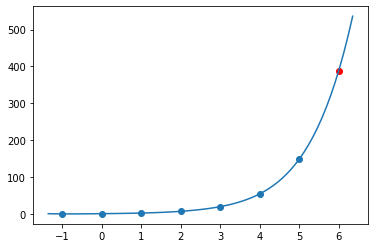

An approximation for f(6) is 387.16


In [23]:
points = [(x, np.exp(x)) for x in range(-1, 6)]
x_0 = 6

approx = approximate(points, x_0, show_axis=False, show_Ls=False)
print('An approximation for f({}) is {:.2f}'.format(x_0, approx))

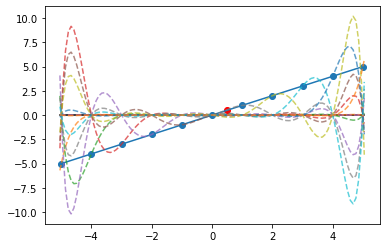

An approximation for f(0.5) is 0.50


In [24]:
points = [(x, x) for x in range(-5, 6)]
x_0 = 0.5

approx = approximate(points, x_0, show_axis=True)
print('An approximation for f({}) is {:.2f}'.format(x_0, approx))

# **Tema 3: Regressão Linear ou solução de EDOs ou interpolação de integração**

## Revisão Teórica (TODO)

## Implementação

## Comparação com a implementação do NumPy

## Aplicação

# **Tema 4: Método dos Autovalores e Autovetores**

## Revisão Teórica

Dada uma matriz $A \in \mathbb{M}_n(\mathbb{R})$, são seus autovetores aqueles vetores $v \in \mathbb{R}_n$ tais que
$$Av = \lambda v, \quad \lambda \in \mathbb{R}$$
e seus autovalores são os correspondentes valores de $\lambda$.  
  
### Método de Francis
Para calcular esses valores para matrizes $A$ simétricas, utilizaremos o Método de Francis, que consiste em decompor A em diversas matrizes iterativamente $Q, R$ tais que $Q_i$ sejam ortogonais e $R_i$ sejam triangulares superiores.  
Utilizando o método QR, obteremos:
$$A_1 = Q_1R_1$$
$$A_2 = R_1Q_1,\: \text{decomporemos ainda em}$$
$$A_2 = Q_2R_2$$
$$\text{e assim sucessivamente, tal que}$$
$$A_k = R_{k-1}Q_{k-1}$$  
$$\text{como}\, A_k = (Q_1\dots Q_{k-1})^TA(Q_1\dots Q_{k-1}),$$
$$\text{tomando}\: V = Q_1\dots Q_{k-1}, \, \text{temos}$$
$$A_k = V^TAV, \, \text{logo, são semelhantes}$$  
Como $A$ e $A_k$ são semelhantes, ambas têm o mesmo polinômio característico e consequentemente os mesmos autovalores. Como $A_k$ tende a uma matriz diagonal, podemos também enxergar $V$ como a matriz de mudança de base para a base de autovetores de $A$. Dessa forma, os elementos da diagonal de $A_k$ fornecem uma boa aproximação para os autovalores de $A$ e os vetores-coluna de $V$ aproximam os respectivos autovetores de $A$.  
  
Com esse método, conseguimos obter uma aproximação para os autovalores e os autovetores de matrizes simétricas. Vamos utilizar isso para implementar a decomposição SVD.  

### Decomposição SVD Truncada
A decomposição SVD truncada consiste em fatorar uma matriz $A \in \mathbb{M}_{m\times n}(\mathbb{R})$ de posto $p > 0$ em três matrizes tais que  
  
$$ A = \hat U \hat \Sigma \hat V^T, \, \text{onde}$$
$$k = min(m, n)\, \text{e} $$
$$ \hat U \in \mathbb{M}_{m \times k}(\mathbb{R}), \, 
\hat \Sigma \in \mathbb{M}_{k\times k}(\mathbb{R}), \,
\hat V^T \in \mathbb{M}_{k\times n}(\mathbb{R})$$  

E $\hat \Sigma$ é matriz diagonal e os elementos $\sigma_i$ da diagonal de $\hat \Sigma$ são positivos e ordenados decrescentemente. Os valores $\sigma$ são chamados valores singulares de $A$.  
Considere a matriz simétrica $A^TA$. Se $A$ possui decomposição SVD completa, então $A = U \Sigma V^T$, com $U$ e $V^T$ ortogonais., então  

$$A^TA = (V \Sigma U^T)(U \Sigma V^T) \\
= V\Sigma^2V^T$$  

Oberve que, por conta das dimensões da matriz $\Sigma$, a simplificação utilizada acima de que $\Sigma^T = \Sigma$ não vale, já que, embora seja diagonal, $\Sigma$ não é quadrada. Mesmo assim, a matriz $\Sigma$ irá conter $p$ elementos na sua diagonal, e o resto será preenchido por 0. Então quando se indica $\Sigma^2$, leia-se a matriz quadrada de dimensões apropriadas cujos $p$ primeiros elementos da diagonal são os valores singulares ao quadrado de $A$. Podemos obter as matrizes $V$ e $\Sigma^2$ através do método de Francis descrito acima.  
Com isso, podemos obter a matriz $\hat \Sigma$ truncando a matriz $\Sigma^2$ para que seja $k \times k$ e extraindo a raíz quadrada dos elementos da diagonal. Podemos também obter a matriz $\hat V^T$ truncando a matriz $V^T$ para que tenha dimensões $k \times n$. Com essas matrizes, conseguimos encontrar $\hat U$ fazendo
$$\hat U = A \hat V \hat \Sigma^{-1}$$
Essa forma de encontrar $\hat U$ é mais otimizada do que repetir o raciocínio para a matriz $AA^T$, já que economizaremos uma chamada ao método de Francis (que é bem caro).
  
### Compressão de Imagens
Podemos representar uma imagem como um tensor $m \times n \times c$ onde $c$ é o número de canais de cor da imagem. Podemos também pensar na imagem como $c$ matrizes $m \times n$. Para simplicidade, vamos usar como exemplo uma imagem _grayscale_ ($c = 1$). Podemos fatorar essa matriz $A$ em sua decomposição SVD truncada
$$A = \hat U \hat \Sigma \hat V^T $$
As dimensões das matrizes serão, respectivamente, $m \times k, k \times k, k \times n$. Essa representação da matriz ocupará $k(k + m + n)$ bytes. Uma maneira de diminuir a quantidade de bytes na repreentação da image seria utilizando menos valores singulares na matriz $\hat \Sigma$. A representação de $A$ utilizando $s$ valores singulares pode ser obtida truncando as matrizes $\hat U, \hat \Sigma, \hat V^T $ para que sejam de dimensões $m \times s, s \times s, s \times n$. Essa representação ocupa $s(s + m + n)$ bytes e tem a vantagem da flexibilidade na escolha de $s$. Abaixo, exibimos diversas imagens comprimidas e seus respectivos valores de $s$, além do espaço em disco e o erro médio quadrado por pixel.  
Para imagens com mais de um canal, basta aplicar o mesmo raciocínio em cada canal de cor, e uní-los para reconstruir a imagem.

## Implementação (Francis e SVD)

In [25]:
EPSILON = 1e-6
MAX_ITERATIONS = 1000


def non_diagonal_error(B):
    """
    Return absolute max value of
    B outside the main diagonal
    """
    mask = np.ones(B.shape, dtype=bool)
    np.fill_diagonal(mask, 0)     # Mask is true in all indices except diagonal
    return np.abs(B)[mask].max()  # Return abs max element of the masked matrix



def francis(B, tol=EPSILON, max_iterations=MAX_ITERATIONS, print_error=False):
    """
    Given B a symmetric square matrix,
    returns a tuple with B's eigenvectors as
    the first element and their eigenvalues as
    the second element.
    The eigenvectors are returned as a matrix
    where the columns of the matrix are the
    eigenvectors. (n x n)

    NOTE: all values are an approxumation with
          tolerance 'tol'
    """
    if B.shape[0] != B.shape[1]: raise ValueError("Matrix must be square!")

    iterations = 0
    n = B.shape[0]
    B_k, V = B, np.eye(n)   # Initialize V as identity for first dot protuct

    while iterations < max_iterations and non_diagonal_error(B_k) > tol:
        Q, R = np.linalg.qr(B_k)
        B_k = np.dot(R, Q)
        V = np.dot(V, Q)
        iterations += 1

    eigenvalues = np.diag(B_k)
    eigenvectors = V

    if (iterations >= max_iterations): print(f'Francis Method exceeded max iterations with dimensions ({n}x{n}). Might not have converged.')

    if print_error: print('Took {} iterations with off-diagonal error {}'.format(iterations, non_diagonal_error(B_k)))
    return eigenvectors, eigenvalues

In [26]:
def truncated_svd(A, tol=1e-4, max_iterations=1e3):
    """
    Find truncated SVD decomposition of A.
    Find matrices such that A = U*S*V^T, where
        A is m x n
        U is m, min(m, n)
        S is a diagonal matrix of min(m, n) x min(m, n)
        V^T is min(m, n), n
    
    Returns tuple with (U, np.diag(S), V^T)
    """
    A = np.array(A)
    m, n = A.shape
    min_dim = min(m, n)

    V, eigenvalues = francis(np.dot(A.T, A), tol=tol, max_iterations=max_iterations)
    singular_vals = np.sqrt(eigenvalues[:min_dim])   # Truncate singular values

    V = V[:, :min_dim] # Truncate V

    U = np.dot(np.dot(A, V), np.diag(1/singular_vals))

    return U, singular_vals, V.T

## Comparação com a implementação do NumPy

In [27]:
import random


def svd_error(s1, s2):
    return np.sum(np.abs((s1 - s2)**2))


def compare_svd(max_m = 30, max_n = 30, n_tests = 10):
    """
    Returns tuple with Xs (m * n), errors and execution times
    as per _compare_implementation_ standard. The test cases
    are run with matrices of random m, n in range max_m, max_n
    """
    Ms = sorted([random.randint(2, max_m + 1) for i in range(n_tests)])
    Ns = sorted([random.randint(2, max_n + 1) for i in range(n_tests)])
    Xs = []
    errors = []

    our_times = []
    np_times = []

    np.random.seed(42)
    for m, n in zip(Ms, Ns):
        Xs.append(m*n)

        A = 255*np.random.rand(m, n)
        np_time, (U, s, V) = numpy_wrapper(np.linalg.svd, A, full_matrices=False)
        our_time, (Up, sp, Vp) = implementation_wrapper(truncated_svd, A)

        our_times.append(our_time)
        np_times.append(np_time)

        errors.append(svd_error(s, sp))

    return Xs, errors, (our_times, np_times)

Francis Method exceeded max iterations with dimensions (27x27). Might not have converged.
Francis Method exceeded max iterations with dimensions (31x31). Might not have converged.


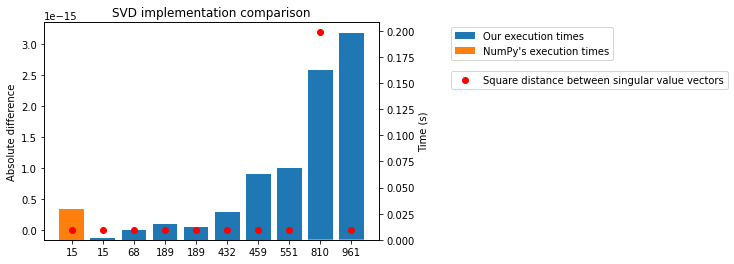

In [28]:
Xs, errors, times = compare_svd()
compare_implementation(Xs, errors, times, linearize_x=True, x_label='Matrix size (m*n)',\
                       title='SVD implementation comparison', err_metric='Square distance between singular value vectors')

## Aplicação: Compressão de Imagens

**OBS:** embora a nossa implementação da decomposição SVD esteja correta (vide os testes acima), o algoritmo utilizado (através do método de Francis) é muito "ingênuo". Tentamos rodá-lo na aplicação de compressão de imagens e ele demora muito tempo para o método de Francis convergir (mais de 10 minutos e ainda não tinha convergido). Portanto, decidimos utilizar a implementação do NumPy para que a visualização seja mais rápida.

In [29]:
import imageio


def mean_square_error(img1, img2):
    '''
    Returns mean square difference between
    two matrices
    '''
    if img1.shape != img2.shape:
        raise Exception("Arrays must be of the same shape")
    
    n_pixels = img1.shape[0] * img1.shape[1]
    total_value = np.sum((np.sum(img1, axis=2)/3 - np.sum(img2, axis=2)/3)**2)

    return np.sqrt(total_value/n_pixels)


def normalize(img):
    '''
    Return img normalized to interval [0, 255] as
    an integer matrix
    '''
    return ((img - img.min())*\
            (255/(img.max()-img.min()))).astype('uint8')


def grayscale(img):
    '''
    Return np array with the grayscale
    form of the input _img_.
    '''
    img_gray = np.zeros(img.shape[:2])
    img_gray += img[:,:,0]
    img_gray += img[:,:,1]
    img_gray += img[:,:,2]

    img_gray *= 255.0/img_gray.max()
    return img_gray

In [30]:
def compress(img, modes, return_matrices=False):
    '''
    Return np array containing the compressed version of
    img by using _modes_ singular values in compression.
    Set _return_matrices_ to True to return instead an array
    of tuples containing each the compressed matrices that
    can be multiplied to generate the resulting image. The
    matrices are stored as (U', s', Vh') and each channel
    can be reconstructed by multiplying U' * np.diag(s') * Vh'.
    '''

    channel_matrices = []

    m, n = img.shape[:2]
    if len(img.shape) < 3: img = img.reshape((m, n, 1))

    img_compressed = np.zeros(img.shape)

    for channel in range(img.shape[2]):
        U, s, Vh = np.linalg.svd(img[:,:,channel], full_matrices=False)

        U_prime = U[:, :modes]
        s_prime = s[:modes]
        Vh_prime = Vh[:modes, :]

        channel_matrices.append((U_prime, s_prime, Vh_prime))

        compressed_channel = np.dot(np.dot(U_prime, np.diag(s_prime)), Vh_prime)
        img_compressed[:,:,channel] = compressed_channel

    img_compressed = normalize(img_compressed)

    if return_matrices: return channel_matrices
    return img_compressed

In [31]:
def visualize_compression(img_url, initial_mode=1, modes_step=6, n_rows=2, make_grayscale=False):
    '''
    Visualize compression by displaying different compression
    levels and their respective error and size.

    initial_mode:   initial number of singular values to use in compression
    modes_step:     how much to increase modes between iteration
    n_rows:         how many rows to display. Value must be >= 1
    make_grayscale: whether to convert initial image to grayscale
    '''
    if make_grayscale: img = normalize(grayscale(imageio.imread(img_url)))
    else: img = normalize(imageio.imread(img_url))

    m, n = img.shape[:2]

    channels = 1
    if len(img.shape) >= 3: channels = img.shape[2]

    img = img.reshape((m, n, channels))
    original_img_size = channels*m*n/1000

    N_COLS = 3
    fig, axs = plt.subplots(n_rows+1, N_COLS, figsize=(20, 4*(n_rows + 1)))

    x_modes = []
    sizes = []
    errors = []

    modes = initial_mode
    for i, ax in enumerate(axs.flat):
        if i >= n_rows*N_COLS: break
        
        ax.set_yticks([])
        ax.set_xticks([])

        x_modes.append(modes)
        size = min(channels*modes*(m + n + modes)/1000, original_img_size)
        sizes.append(100*size/original_img_size)

        compressed_img = compress(img, modes)
        errors.append(mean_square_error(img, compressed_img))

        if channels == 1: compressed_img = compressed_img.reshape((m, n))

        ax.imshow(compressed_img, cmap='gray')
        ax.set_title(f'{modes} Singular Values ({size} Kb)')

        modes += modes_step

    error_ax = plt.subplot(n_rows + 1, 2, 2*n_rows + 2)
    error_ax.set_xticks(x_modes)
    error_ax.set_xlabel('Number of Singular Values used in compression')
    size_ax = error_ax.twinx()

    error_ax.plot(x_modes, errors, color='red')
    error_ax.set_ylabel('Mean Pixel Error\n(Red)')

    size_ax.plot(x_modes, sizes)
    # size_ax.set_ylim((0, 100))
    size_ax.set_ylabel('Relative size to original Image (%)\n(Blue)')

    og_img_ax = plt.subplot(n_rows + 1, 2, 2*n_rows + 1)
    og_img_ax.set_yticks([])
    og_img_ax.set_xticks([])
    og_img_ax.set_title(f'Original Image ({original_img_size} Kb)')

    if channels == 1: img = img.reshape((m, n))
    og_img_ax.imshow(img, cmap='gray')

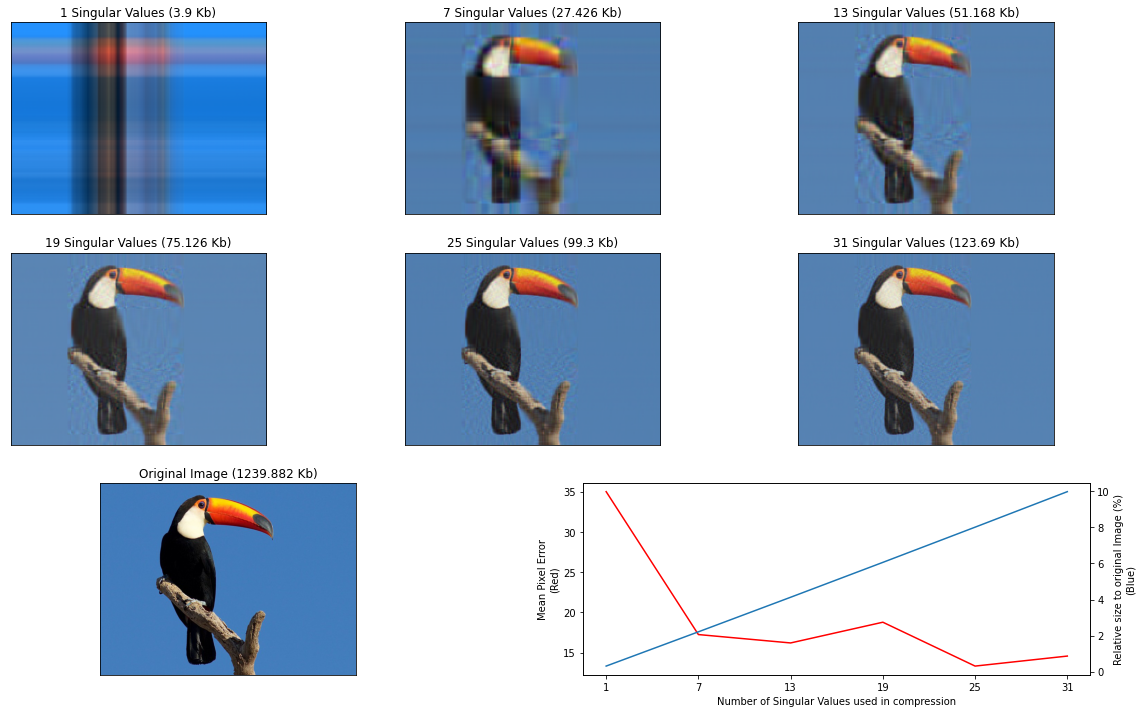

In [32]:
toucan_url = 'https://test.cdn.download.ams.birds.cornell.edu/api/v1/asset/96276931/900'
visualize_compression(toucan_url)

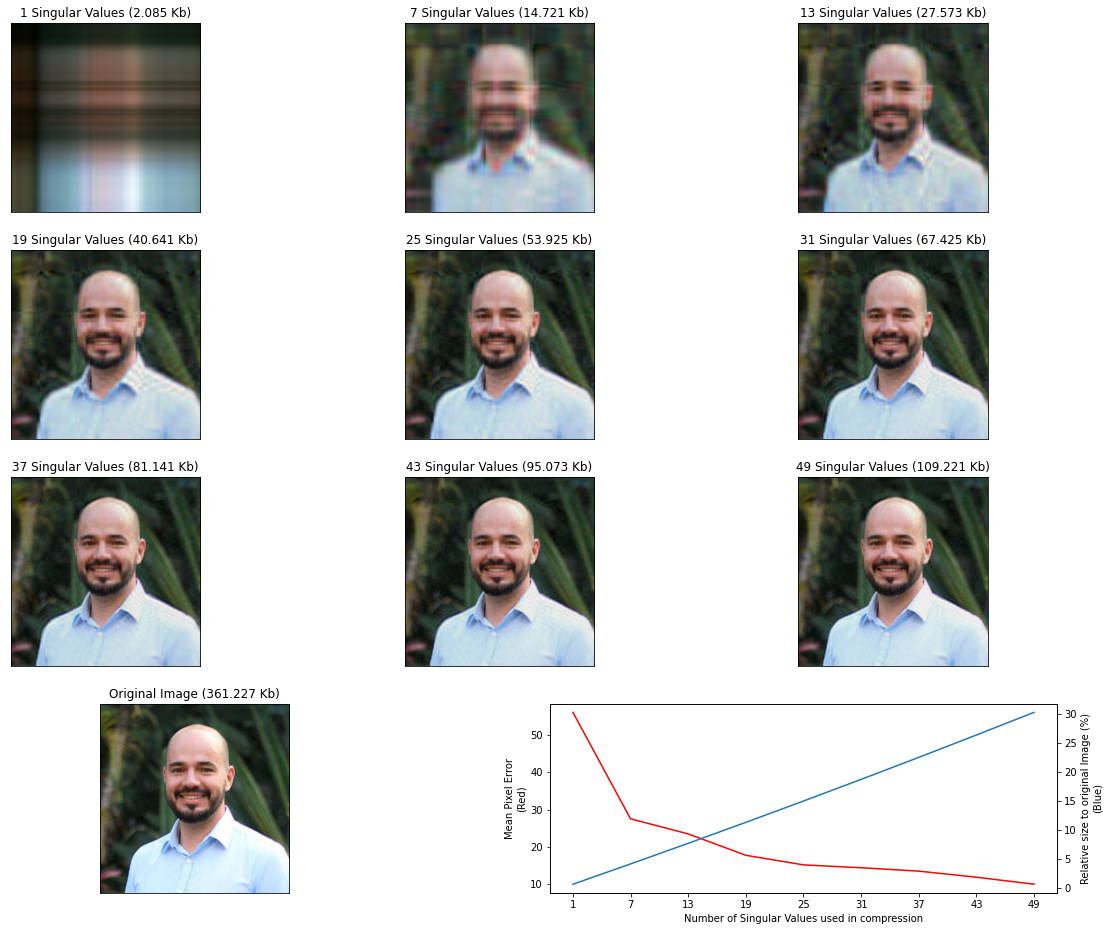

In [33]:
mo_url = 'https://avatars3.githubusercontent.com/u/3063242?s=400&u=ea38dd5b7528fa6f2e3ee3cdd5171e9ffc481ef0&v=4'
# <3
visualize_compression(mo_url, n_rows=3)

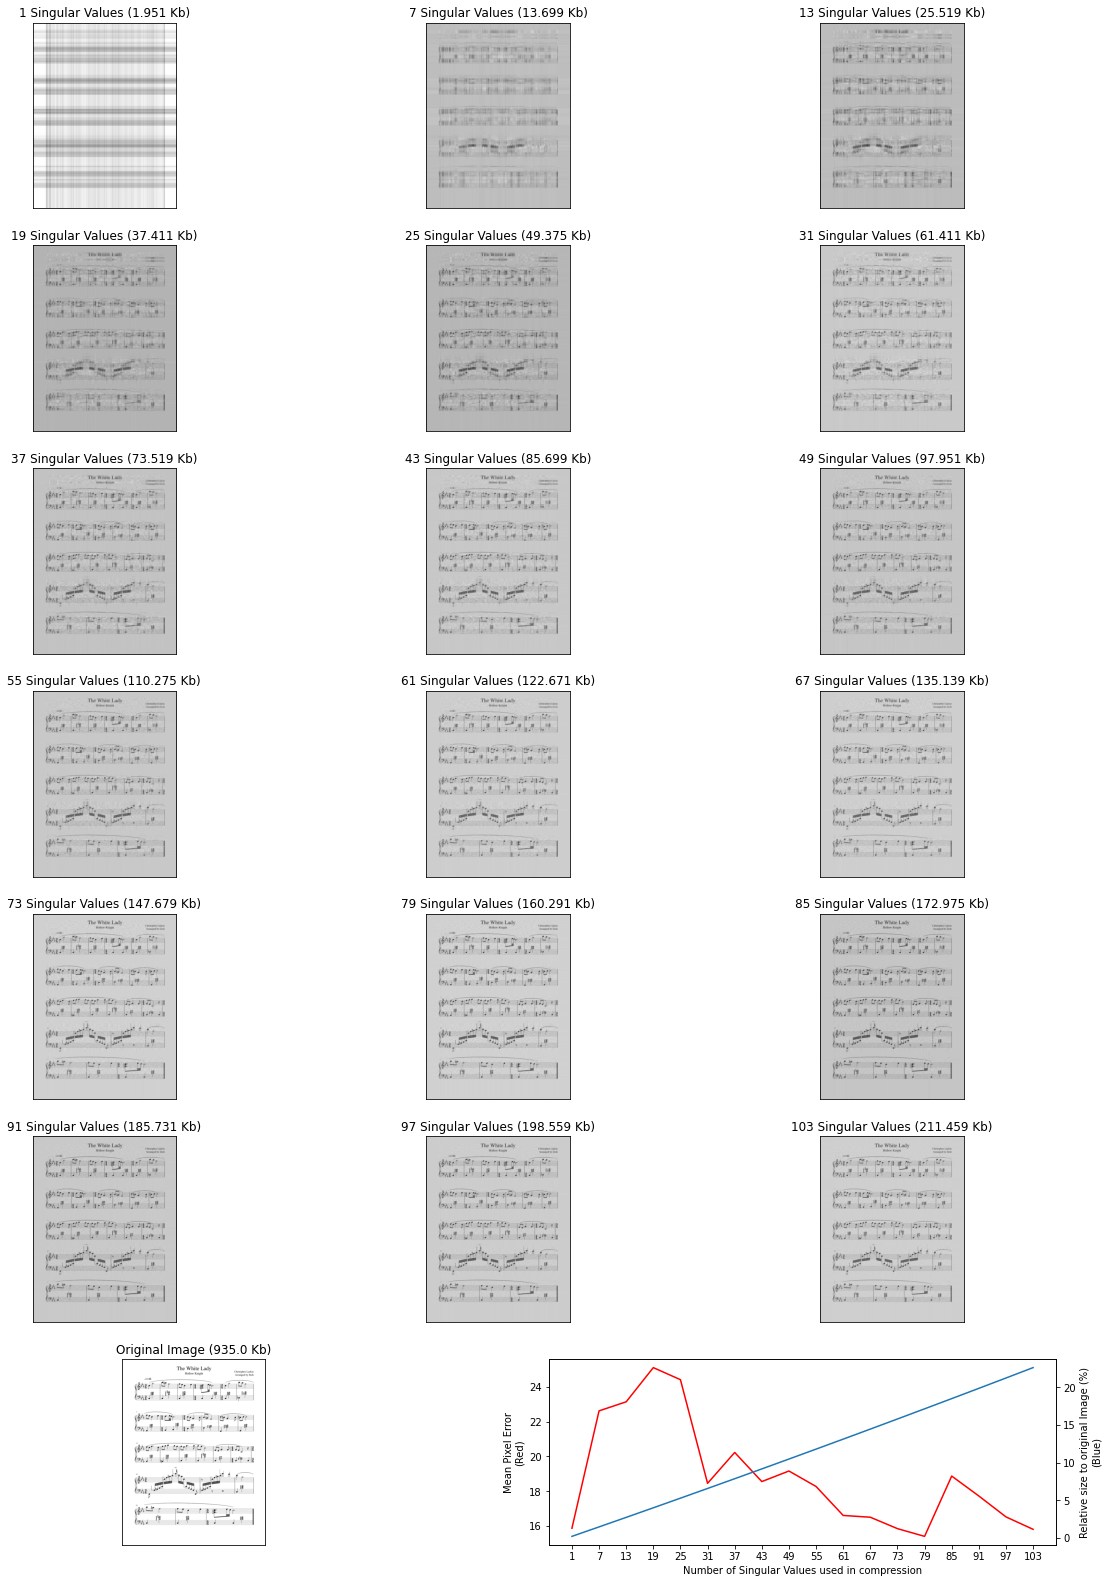

In [34]:
score_url = 'https://musescore.com/static/musescore/scoredata/gen/7/4/3/4792347/4faed97251bfa97fbaf848af47de7325574896dd/score_0.png@850x1100?no-cache=1584697174&bgclr=ffffff'
visualize_compression(score_url, n_rows=6)